# Model 4b Remaining Experiments (4/9)

## Status
✅ **Completed (5/9):** 4b_Baseline (R²=+0.6852), 4b2_StrongReg, 4b3_LRSchedule, 4b4_FullNorm, 4b5_Combined

🔄 **This notebook (4/9):** 4b6_EfficientNet ⭐⭐, 4b7_MobileNet, 4b8_DenseNet, 4b9_EfficientNet_Combined ⭐⭐⭐

## Fix
Uses `timm`'s `forward_features()` for EfficientNet/MobileNet.

## Debug
`DEBUG_MODE = True` in Cell 3: 2 epochs/phase (~20 min)
`DEBUG_MODE = False`: Full training (~3 hours)

---

## Part 1: Setup & Data Preparation

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm.auto import tqdm
import copy
from datetime import datetime

# Install timm for EfficientNet/MobileNet experiments
try:
    import timm
    print("✅ timm library already installed")
except ImportError:
    print("⏳ Installing timm library for EfficientNet/MobileNet...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "timm", "-q"])
    import timm
    print("✅ timm library installed successfully!")

sns.set_style('whitegrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✓ Imports complete")

✅ timm library already installed
Using device: cpu
✓ Imports complete


In [15]:
# ================================================================
# CONFIGURATION: 4 REMAINING EXPERIMENTS
# ================================================================

# 🐛 DEBUG MODE
DEBUG_MODE = False  # Change to False for full training

BATCH_SIZE = 16
TARGET_COLS = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']
COMPETITION_WEIGHTS = torch.tensor([0.1, 0.1, 0.1, 0.2, 0.5])

if DEBUG_MODE:
    print("\n" + "🐛"*40)
    print("DEBUG MODE: 2 epochs/phase")
    print("🐛"*40 + "\n")

def get_epochs(full):
    return 2 if DEBUG_MODE else full

VARIATIONS = {
    '4b6_EfficientNet': {
        'phase1_epochs': get_epochs(15), 'phase2_epochs': get_epochs(30),
        'phase1_lr': 3e-4, 'phase2_lr': 3e-4, 'phase2_backbone_lr': 1e-5,
        'weight_decay': 1e-4, 'hidden_dim': 256, 'dropout': 0.2,
        'backbone': 'efficientnet_b0', 'use_scheduler': False, 'use_full_norm': False,
        'requires_timm': True, 'description': 'EfficientNet-B0', 'expected_kaggle': '0.54-0.58 ⭐⭐'
    },
    '4b7_MobileNet': {
        'phase1_epochs': get_epochs(15), 'phase2_epochs': get_epochs(30),
        'phase1_lr': 3e-4, 'phase2_lr': 3e-4, 'phase2_backbone_lr': 1e-5,
        'weight_decay': 1e-4, 'hidden_dim': 256, 'dropout': 0.2,
        'backbone': 'mobilenetv3_large_100', 'use_scheduler': False, 'use_full_norm': False,
        'requires_timm': True, 'description': 'MobileNetV3', 'expected_kaggle': '0.52-0.56'
    },
    '4b8_DenseNet': {
        'phase1_epochs': get_epochs(15), 'phase2_epochs': get_epochs(30),
        'phase1_lr': 3e-4, 'phase2_lr': 3e-4, 'phase2_backbone_lr': 1e-5,
        'weight_decay': 1e-4, 'hidden_dim': 256, 'dropout': 0.2,
        'backbone': 'densenet121', 'use_scheduler': False, 'use_full_norm': False,
        'description': 'DenseNet121', 'expected_kaggle': '0.52-0.56'
    },
    '4b9_EfficientNet_Combined': {
        'phase1_epochs': get_epochs(15), 'phase2_epochs': get_epochs(20),
        'phase1_lr': 3e-4, 'phase2_lr': 3e-4, 'phase2_backbone_lr': 1e-5,
        'weight_decay': 5e-4, 'hidden_dim': 256, 'dropout': 0.3,
        'backbone': 'efficientnet_b0', 'use_scheduler': True,
        'scheduler_factor': 0.5, 'scheduler_patience': 3, 'use_full_norm': True,
        'requires_timm': True, 'description': 'EfficientNet+ALL', 'expected_kaggle': '0.55-0.60 ⭐⭐⭐'
    }
}

print("="*80)
print("REMAINING EXPERIMENTS (4/9)")
print("="*80)
try:
    import timm
    TIMM_AVAILABLE = True
    print("✅ timm available")
except:
    TIMM_AVAILABLE = False
    print("⚠️  timm NOT available!")

print(f"\nExperiments ({len(VARIATIONS)}):")
for name, cfg in VARIATIONS.items():
    ep = f"P1:{cfg['phase1_epochs']}ep P2:{cfg['phase2_epochs']}ep"
    print(f"  {name}: {ep} - {cfg.get('expected_kaggle', '')}")

print(f"\n⏱️  {'DEBUG: ~20 min' if DEBUG_MODE else 'FULL: ~3 hours'}")
print("="*80)

REMAINING EXPERIMENTS (4/9)
✅ timm available

Experiments (4):
  4b6_EfficientNet: P1:15ep P2:30ep - 0.54-0.58 ⭐⭐
  4b7_MobileNet: P1:15ep P2:30ep - 0.52-0.56
  4b8_DenseNet: P1:15ep P2:30ep - 0.52-0.56
  4b9_EfficientNet_Combined: P1:15ep P2:20ep - 0.55-0.60 ⭐⭐⭐

⏱️  FULL: ~3 hours


In [16]:
# Load data
train_enriched = pd.read_csv('competition/train_enriched.csv')
train_enriched['Sampling_Date'] = pd.to_datetime(train_enriched['Sampling_Date'])
train_enriched['full_image_path'] = train_enriched['image_path'].apply(lambda x: f'competition/{x}')

print(f"Full dataset loaded: {len(train_enriched)} images")
print(f"Targets: {TARGET_COLS}")

# Calculate TWO sets of normalization stats:
# 1. Full dataset (357 images) - for experiments with use_full_norm=True
target_means_full = torch.tensor([train_enriched[col].mean() for col in TARGET_COLS], dtype=torch.float32)
target_stds_full = torch.tensor([train_enriched[col].std() for col in TARGET_COLS], dtype=torch.float32)

print("\n1. Full dataset normalization (357 images):")
for i, col in enumerate(TARGET_COLS):
    print(f"  {col:15s}: mean={target_means_full[i]:.2f}g, std={target_stds_full[i]:.2f}g")

# 2. Split-based (285 train images) - for experiments with use_full_norm=False
train_data, val_data = train_test_split(train_enriched, test_size=0.2, random_state=42)
target_means_split = torch.tensor([train_data[col].mean() for col in TARGET_COLS], dtype=torch.float32)
target_stds_split = torch.tensor([train_data[col].std() for col in TARGET_COLS], dtype=torch.float32)

print("\n2. Split normalization (285 train images):")
for i, col in enumerate(TARGET_COLS):
    print(f"  {col:15s}: mean={target_means_split[i]:.2f}g, std={target_stds_split[i]:.2f}g")

print(f"\n✓ Train/val split: {len(train_data)} train, {len(val_data)} val")
print("✓ Both normalization stats calculated")

Full dataset loaded: 357 images
Targets: ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']

1. Full dataset normalization (357 images):
  Dry_Green_g    : mean=26.62g, std=25.40g
  Dry_Dead_g     : mean=12.04g, std=12.40g
  Dry_Clover_g   : mean=6.65g, std=12.12g
  GDM_g          : mean=33.27g, std=24.94g
  Dry_Total_g    : mean=45.32g, std=27.98g

2. Split normalization (285 train images):
  Dry_Green_g    : mean=27.49g, std=26.19g
  Dry_Dead_g     : mean=12.01g, std=12.50g
  Dry_Clover_g   : mean=6.26g, std=11.75g
  GDM_g          : mean=33.74g, std=25.62g
  Dry_Total_g    : mean=45.75g, std=28.86g

✓ Train/val split: 285 train, 72 val
✓ Both normalization stats calculated


In [17]:
# This cell intentionally left empty - normalization moved to Cell 4

In [18]:
# Prepare tabular features for auxiliary pretraining
weather_features = [
    'rainfall_7d', 'rainfall_30d',
    'temp_max_7d', 'temp_min_7d', 'temp_mean_7d', 'temp_mean_30d', 'temp_range_7d',
    'et0_7d', 'et0_30d',
    'water_balance_7d', 'water_balance_30d',
    'days_since_rain', 'daylength', 'season'
]

# Scale continuous features
continuous_features = weather_features + ['Pre_GSHH_NDVI', 'Height_Ave_cm']
scaler = StandardScaler()
train_data[continuous_features] = scaler.fit_transform(train_data[continuous_features])
val_data[continuous_features] = scaler.transform(val_data[continuous_features])

# Encode categorical
le_state = LabelEncoder()
le_species = LabelEncoder()
train_data['State_encoded'] = le_state.fit_transform(train_data['State'])
train_data['Species_encoded'] = le_species.fit_transform(train_data['Species'])
val_data['State_encoded'] = le_state.transform(val_data['State'])
val_data['Species_encoded'] = le_species.transform(val_data['Species'])

num_states = len(le_state.classes_)
num_species = len(le_species.classes_)

print("✓ Tabular features prepared")
print(f"  States: {num_states} ({list(le_state.classes_)})")
print(f"  Species: {num_species}")

✓ Tabular features prepared
  States: 4 (['NSW', 'Tas', 'Vic', 'WA'])
  Species: 15


### Dataset Classes

In [19]:
class NormalizedDataset(Dataset):
    """Image-only dataset with normalized targets."""
    def __init__(self, dataframe, target_means, target_stds, augment=False):
        self.df = dataframe.reset_index(drop=True)
        self.target_means = target_means
        self.target_stds = target_stds
        
        transform_list = [transforms.Resize((224, 224))]
        
        if augment:
            transform_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(10),
            ])
        
        transform_list.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        self.transform = transforms.Compose(transform_list)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['full_image_path']).convert('RGB')
        img = self.transform(img)
        
        targets = torch.tensor(row[TARGET_COLS].values.astype('float32'), dtype=torch.float32)
        targets_normalized = (targets - self.target_means) / self.target_stds
        
        return {
            'image': img,
            'targets': targets_normalized,
            'targets_original': targets
        }

class MultimodalDataset(Dataset):
    """Multimodal dataset for auxiliary pretraining."""
    def __init__(self, dataframe, target_means, target_stds, augment=False):
        self.df = dataframe.reset_index(drop=True)
        self.target_means = target_means
        self.target_stds = target_stds
        
        transform_list = [transforms.Resize((224, 224))]
        
        if augment:
            transform_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(10),
            ])
        
        transform_list.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        self.transform = transforms.Compose(transform_list)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Image
        img = Image.open(row['full_image_path']).convert('RGB')
        img = self.transform(img)
        
        # Tabular features
        weather = torch.tensor(row[weather_features].values.astype('float32'), dtype=torch.float32)
        ndvi = torch.tensor(row['Pre_GSHH_NDVI'], dtype=torch.float32)
        height = torch.tensor(row['Height_Ave_cm'], dtype=torch.float32)
        state = torch.tensor(row['State_encoded'], dtype=torch.long)
        species = torch.tensor(row['Species_encoded'], dtype=torch.long)
        
        # Targets
        targets = torch.tensor(row[TARGET_COLS].values.astype('float32'), dtype=torch.float32)
        targets_normalized = (targets - self.target_means) / self.target_stds
        
        return {
            'image': img,
            'weather': weather,
            'ndvi': ndvi,
            'height': height,
            'state': state,
            'species': species,
            'targets': targets_normalized,
            'targets_original': targets
        }

print("✓ Dataset classes defined")
print("✓ Datasets will be created for each experiment with appropriate normalization")

✓ Dataset classes defined
✓ Datasets will be created for each experiment with appropriate normalization


### Model Architecture

In [20]:
def get_backbone_and_features(backbone_name):
    """FIXED timm support."""
    if backbone_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        backbone = nn.Sequential(*list(model.children())[:-1])
        feature_dim = 512
    elif backbone_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        backbone = nn.Sequential(model.features, nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)))
        feature_dim = 1024
    elif backbone_name in ['efficientnet_b0', 'mobilenetv3_large_100']:
        # ✅ FIXED: Use timm's forward_features()
        if not TIMM_AVAILABLE:
            raise ImportError(f"timm required for {backbone_name}")
        import timm

        class TimmBackbone(nn.Module):
            def __init__(self, model):
                super().__init__()
                self.model = model
            def forward(self, x):
                features = self.model.forward_features(x)
                if len(features.shape) == 4:  # [B,C,H,W]
                    features = features.mean([2, 3])
                return features.unsqueeze(-1).unsqueeze(-1)

        model = timm.create_model(backbone_name, pretrained=True)
        backbone = TimmBackbone(model)
        feature_dim = 1280 if backbone_name == 'efficientnet_b0' else 960
    else:
        raise ValueError(f"Unknown: {backbone_name}")
    return backbone, feature_dim

class AuxiliaryPretrainedModel(nn.Module):
    def __init__(self, backbone_name='resnet18', num_outputs=5, hidden_dim=256,
                 dropout=0.2, num_states=4, num_species=15):
        super().__init__()
        self.backbone, feature_dim = get_backbone_and_features(backbone_name)
        self.backbone_name = backbone_name
        self.feature_dim = feature_dim
        self.ndvi_head = nn.Linear(feature_dim, 1)
        self.height_head = nn.Linear(feature_dim, 1)
        self.weather_head = nn.Linear(feature_dim, 14)
        self.state_head = nn.Linear(feature_dim, num_states)
        self.species_head = nn.Linear(feature_dim, num_species)
        self.biomass_head = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden_dim, num_outputs)
        )
    def forward(self, x, mode='biomass'):
        features = self.backbone(x).flatten(1)
        if mode == 'auxiliary':
            return {'ndvi': self.ndvi_head(features), 'height': self.height_head(features),
                    'weather': self.weather_head(features), 'state': self.state_head(features),
                    'species': self.species_head(features)}
        else:
            return self.biomass_head(features)

print("✓ Model with FIXED timm support")

✓ Model with FIXED timm support


### Utility Functions

In [21]:
def calculate_competition_r2(predictions, targets):
    """Calculate competition R² (weighted)."""
    per_target_r2 = []
    competition_r2 = 0
    
    weights = COMPETITION_WEIGHTS.numpy()
    
    for i in range(5):
        r2 = r2_score(targets[:, i], predictions[:, i])
        per_target_r2.append(r2)
        competition_r2 += weights[i] * r2
    
    return competition_r2, per_target_r2

def auxiliary_loss(predictions, targets):
    """Multi-task loss for predicting tabular features."""
    loss_ndvi = F.mse_loss(predictions['ndvi'].squeeze(), targets['ndvi'])
    loss_height = F.mse_loss(predictions['height'].squeeze(), targets['height'])
    loss_weather = F.mse_loss(predictions['weather'], targets['weather'])
    loss_state = F.cross_entropy(predictions['state'], targets['state'])
    loss_species = F.cross_entropy(predictions['species'], targets['species'])
    
    # Weighted combination
    total_loss = (
        0.2 * loss_ndvi + 
        0.2 * loss_height + 
        0.3 * loss_weather + 
        0.15 * loss_state + 
        0.15 * loss_species
    )
    
    return total_loss, {
        'ndvi': loss_ndvi.item(),
        'height': loss_height.item(),
        'weather': loss_weather.item(),
        'state': loss_state.item(),
        'species': loss_species.item()
    }

print("✓ Utility functions defined")

✓ Utility functions defined


---
## Part 2: Training Functions

In [22]:
def train_phase1(model, train_loader, val_loader, num_epochs, lr, variation_name):
    """Phase 1: Train to predict tabular features from images."""
    print("\n" + "="*80)
    print(f"PHASE 1: AUXILIARY PRETRAINING - {variation_name}")
    print("="*80 + "\n")
    
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    history = {
        'train_loss': [], 
        'val_loss': [], 
        'val_ndvi_mae': [], 
        'val_state_acc': [],
        'val_species_acc': []
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images = batch['image'].to(device)
            targets = {
                'ndvi': batch['ndvi'].to(device),
                'height': batch['height'].to(device),
                'weather': batch['weather'].to(device),
                'state': batch['state'].to(device),
                'species': batch['species'].to(device)
            }
            
            optimizer.zero_grad()
            predictions = model(images, mode='auxiliary')
            loss, _ = auxiliary_loss(predictions, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        # Validate
        model.eval()
        val_loss = 0
        ndvi_errors = []
        state_correct = 0
        state_total = 0
        species_correct = 0
        species_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                targets = {
                    'ndvi': batch['ndvi'].to(device),
                    'height': batch['height'].to(device),
                    'weather': batch['weather'].to(device),
                    'state': batch['state'].to(device),
                    'species': batch['species'].to(device)
                }
                
                predictions = model(images, mode='auxiliary')
                loss, _ = auxiliary_loss(predictions, targets)
                val_loss += loss.item() * images.size(0)
                
                # NDVI MAE
                ndvi_errors.extend((predictions['ndvi'].squeeze().cpu() - targets['ndvi'].cpu()).abs().tolist())
                
                # State accuracy
                state_pred = predictions['state'].argmax(dim=1)
                state_correct += (state_pred == targets['state']).sum().item()
                state_total += targets['state'].size(0)
                
                # Species accuracy
                species_pred = predictions['species'].argmax(dim=1)
                species_correct += (species_pred == targets['species']).sum().item()
                species_total += targets['species'].size(0)
        
        val_loss /= len(val_loader.dataset)
        ndvi_mae = np.mean(ndvi_errors)
        state_acc = state_correct / state_total
        species_acc = species_correct / species_total
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_ndvi_mae'].append(ndvi_mae)
        history['val_state_acc'].append(state_acc)
        history['val_species_acc'].append(species_acc)
        
        # Print progress
        print(f"Epoch {epoch+1:2d}/{num_epochs}: "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"NDVI MAE={ndvi_mae:.4f}, State Acc={state_acc:.2%}, Species Acc={species_acc:.2%}")
        
        # Save best checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'model4b_{variation_name}_phase1_best.pth')
            print(f"  💾 Saved Phase 1 checkpoint (val_loss={val_loss:.4f})")
    
    print(f"\n✓ Phase 1 complete! Model learned to predict tabular features from images.")
    print(f"  Final State Accuracy: {state_acc:.2%} (model can 'see' location!)")
    print(f"  Final Species Accuracy: {species_acc:.2%}")
    print(f"  Final NDVI MAE: {ndvi_mae:.4f}\n")
    
    return history

print("✓ train_phase1() defined")

✓ train_phase1() defined


In [23]:
def train_phase2(model, train_loader, val_loader, config, target_means, target_stds, variation_name):
    """Phase 2: Fine-tune for biomass prediction with flexible config."""
    print("\n" + "="*80)
    print(f"PHASE 2: BIOMASS FINE-TUNING - {variation_name}")
    print("="*80 + "\n")
    
    num_epochs = config['phase2_epochs']
    lr_head = config['phase2_lr']
    lr_backbone = config['phase2_backbone_lr']
    weight_decay = config['weight_decay']
    use_scheduler = config.get('use_scheduler', False)
    
    print(f"Config: {num_epochs} epochs, head_lr={lr_head:.2e}, backbone_lr={lr_backbone:.2e}, ")
    print(f"        weight_decay={weight_decay:.2e}, scheduler={use_scheduler}")
    
    model = model.to(device)
    
    # Two learning rates: low for pretrained backbone, higher for new head
    optimizer = torch.optim.AdamW([
        {'params': model.backbone.parameters(), 'lr': lr_backbone},
        {'params': model.biomass_head.parameters(), 'lr': lr_head}
    ], weight_decay=weight_decay)
    
    # Optional LR scheduler
    scheduler = None
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=config['scheduler_factor'], 
            patience=config['scheduler_patience'], verbose=True
        )
        print(f"✓ LR scheduler enabled (factor={config['scheduler_factor']}, patience={config['scheduler_patience']})")
    
    criterion = nn.MSELoss()
    history = {'train_loss': [], 'val_loss': [], 'val_r2': [], 'per_target_r2': [], 'epoch': []}
    best_r2 = -float('inf')
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images = batch['image'].to(device)
            targets = batch['targets'].to(device)
            
            optimizer.zero_grad()
            outputs = model(images, mode='biomass')
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        # Validate
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                targets = batch['targets'].to(device)
                targets_original = batch['targets_original']
                
                outputs = model(images, mode='biomass')
                loss = criterion(outputs, targets)
                val_loss += loss.item() * images.size(0)
                
                # Denormalize for R² calculation
                outputs_denorm = outputs.cpu() * target_stds + target_means
                all_preds.append(outputs_denorm.numpy())
                all_targets.append(targets_original.numpy())
        
        val_loss /= len(val_loader.dataset)
        
        # Calculate R²
        all_preds = np.vstack(all_preds)
        all_targets = np.vstack(all_targets)
        val_r2, per_target_r2 = calculate_competition_r2(all_preds, all_targets)
        
        # Step scheduler if enabled
        if scheduler is not None:
            scheduler.step(val_r2)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_r2'].append(val_r2)
        history['per_target_r2'].append(per_target_r2)
        history['epoch'].append(epoch + 1)
        
        # Print progress
        print(f"Epoch {epoch+1:2d}/{num_epochs}: "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val R²={val_r2:+.4f}")
        
        # Save best checkpoint
        if val_r2 > best_r2:
            best_r2 = val_r2
            torch.save(model.state_dict(), f'model4b_{variation_name}_phase2_best.pth')
            print(f"  💾 New best R²={best_r2:+.4f} - checkpoint saved")
    
    print(f"\n✓ Phase 2 complete! Best R²={best_r2:+.4f}")
    print(f"\nPer-target R² scores (at best epoch):")
    best_epoch_idx = np.argmax(history['val_r2'])
    best_per_target = history['per_target_r2'][best_epoch_idx]
    for i, col in enumerate(TARGET_COLS):
        print(f"  {col:15s}: R²={best_per_target[i]:+.4f}")
    print()
    
    return history, best_r2

print("✓ train_phase2() defined (with LR scheduling support)")

✓ train_phase2() defined (with LR scheduling support)


---
## Part 3: Train All Variations

We'll train each variation sequentially and track results.

In [24]:
# Storage for results from these 4 experiments
new_results = {}

print("="*80)
print("TRAINING REMAINING VARIATIONS (4/9)")
print("="*80)
print(f"\nStarting at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

if DEBUG_MODE:
    print("\n🐛 DEBUG MODE: 2 epochs/phase (~5 min/exp = ~20 min total)")
else:
    print("\n🚀 FULL TRAINING: 15-30 epochs/phase (~45 min/exp = ~3 hours total)")

print(f"\nWill train {len(VARIATIONS)} variations:")
for name, config in VARIATIONS.items():
    ep_info = f"(P1:{config['phase1_epochs']}ep, P2:{config['phase2_epochs']}ep)"
    print(f"  {name}: {ep_info}")
print()

TRAINING REMAINING VARIATIONS (4/9)

Starting at: 2025-11-05 08:45:26

🚀 FULL TRAINING: 15-30 epochs/phase (~45 min/exp = ~3 hours total)

Will train 4 variations:
  4b6_EfficientNet: (P1:15ep, P2:30ep)
  4b7_MobileNet: (P1:15ep, P2:30ep)
  4b8_DenseNet: (P1:15ep, P2:30ep)
  4b9_EfficientNet_Combined: (P1:15ep, P2:20ep)



In [25]:
# Train each variation
for var_name, config in VARIATIONS.items():
    # Skip experiments that require timm if not available
    if config.get('requires_timm', False) and not TIMM_AVAILABLE:
        print(f"\n⏭️  Skipping {var_name} - requires timm library (install: pip install timm)")
        continue
    
    print("\n\n")
    print("#" * 80)
    print(f"# TRAINING VARIATION: {var_name}")
    print(f"# Description: {config['description']}")
    print(f"# Expected Kaggle: {config.get('expected_kaggle', 'N/A')}")
    print(f"# Backbone: {config['backbone']}")
    print("#" * 80)
    
    # Choose normalization stats based on config
    if config['use_full_norm']:
        target_means = target_means_full
        target_stds = target_stds_full
        print(f"✓ Using FULL dataset normalization (357 images)")
    else:
        target_means = target_means_split
        target_stds = target_stds_split
        print(f"✓ Using SPLIT normalization (285 train images)")
    
    # Create datasets with appropriate normalization
    train_dataset_simple = NormalizedDataset(train_data, target_means, target_stds, augment=True)
    train_dataset_multi = MultimodalDataset(train_data, target_means, target_stds, augment=True)
    val_dataset_simple = NormalizedDataset(val_data, target_means, target_stds, augment=False)
    val_dataset_multi = MultimodalDataset(val_data, target_means, target_stds, augment=False)
    
    # Create model with specified backbone
    model = AuxiliaryPretrainedModel(
        backbone_name=config['backbone'],  # ⬅️ Use backbone from config
        num_outputs=5,
        hidden_dim=config['hidden_dim'],
        dropout=config['dropout'],
        num_states=num_states,
        num_species=num_species
    )
    
    print(f"✓ Model created: {config['backbone']} backbone, {model.feature_dim} features")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"  Total parameters: {total_params:,}")
    
    # Create dataloaders
    train_loader_multi = DataLoader(train_dataset_multi, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader_multi = DataLoader(val_dataset_multi, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    train_loader_simple = DataLoader(train_dataset_simple, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader_simple = DataLoader(val_dataset_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    # Phase 1: Auxiliary pretraining
    history_p1 = train_phase1(
        model=model,
        train_loader=train_loader_multi,
        val_loader=val_loader_multi,
        num_epochs=config['phase1_epochs'],
        lr=config['phase1_lr'],
        variation_name=var_name
    )
    
    # Phase 2: Biomass fine-tuning (with updated signature)
    history_p2, best_r2 = train_phase2(
        model=model,
        train_loader=train_loader_simple,
        val_loader=val_loader_simple,
        config=config,  # Pass full config
        target_means=target_means,  # Pass means for denormalization
        target_stds=target_stds,    # Pass stds for denormalization
        variation_name=var_name
    )
    
    # Store results
    new_results[var_name] = {
        'config': config,
        'history_phase1': history_p1,
        'history_phase2': history_p2,
        'best_r2': best_r2,
        'model_checkpoint': f'model4b_{var_name}_phase2_best.pth',
        'target_means': target_means.tolist(),  # Store for submission
        'target_stds': target_stds.tolist()
    }
    
    print(f"\n✅ {var_name} complete! Best R²={best_r2:+.4f}")
    print(f"   Checkpoint: model4b_{var_name}_phase2_best.pth")
    print(f"   Expected Kaggle: {config.get('expected_kaggle', 'N/A')}")




################################################################################
# TRAINING VARIATION: 4b6_EfficientNet
# Description: EfficientNet-B0
# Expected Kaggle: 0.54-0.58 ⭐⭐
# Backbone: efficientnet_b0
################################################################################
✓ Using SPLIT normalization (285 train images)
✓ Model created: efficientnet_b0 backbone, 1280 features
  Total parameters: 5,662,604

PHASE 1: AUXILIARY PRETRAINING - 4b6_EfficientNet



Epoch 1/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/15: Train Loss=1.1298, Val Loss=1.0625, NDVI MAE=0.4511, State Acc=47.22%, Species Acc=36.11%
  💾 Saved Phase 1 checkpoint (val_loss=1.0625)


Epoch 2/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/15: Train Loss=0.7741, Val Loss=0.7503, NDVI MAE=0.4046, State Acc=72.22%, Species Acc=45.83%
  💾 Saved Phase 1 checkpoint (val_loss=0.7503)


Epoch 3/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/15: Train Loss=0.5587, Val Loss=0.5872, NDVI MAE=0.3542, State Acc=80.56%, Species Acc=58.33%
  💾 Saved Phase 1 checkpoint (val_loss=0.5872)


Epoch 4/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/15: Train Loss=0.4957, Val Loss=0.5900, NDVI MAE=0.3904, State Acc=84.72%, Species Acc=62.50%


Epoch 5/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/15: Train Loss=0.4404, Val Loss=0.4960, NDVI MAE=0.3707, State Acc=90.28%, Species Acc=70.83%
  💾 Saved Phase 1 checkpoint (val_loss=0.4960)


Epoch 6/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/15: Train Loss=0.3439, Val Loss=0.4151, NDVI MAE=0.3418, State Acc=88.89%, Species Acc=69.44%
  💾 Saved Phase 1 checkpoint (val_loss=0.4151)


Epoch 7/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/15: Train Loss=0.2965, Val Loss=0.3705, NDVI MAE=0.3431, State Acc=90.28%, Species Acc=76.39%
  💾 Saved Phase 1 checkpoint (val_loss=0.3705)


Epoch 8/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/15: Train Loss=0.2469, Val Loss=0.3714, NDVI MAE=0.3189, State Acc=91.67%, Species Acc=72.22%


Epoch 9/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/15: Train Loss=0.2194, Val Loss=0.3554, NDVI MAE=0.3172, State Acc=91.67%, Species Acc=70.83%
  💾 Saved Phase 1 checkpoint (val_loss=0.3554)


Epoch 10/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/15: Train Loss=0.2677, Val Loss=0.3321, NDVI MAE=0.3444, State Acc=91.67%, Species Acc=73.61%
  💾 Saved Phase 1 checkpoint (val_loss=0.3321)


Epoch 11/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/15: Train Loss=0.2169, Val Loss=0.4001, NDVI MAE=0.3424, State Acc=90.28%, Species Acc=69.44%


Epoch 12/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/15: Train Loss=0.1926, Val Loss=0.3448, NDVI MAE=0.3607, State Acc=93.06%, Species Acc=81.94%


Epoch 13/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/15: Train Loss=0.1874, Val Loss=0.3037, NDVI MAE=0.3316, State Acc=93.06%, Species Acc=79.17%
  💾 Saved Phase 1 checkpoint (val_loss=0.3037)


Epoch 14/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/15: Train Loss=0.1582, Val Loss=0.3388, NDVI MAE=0.3440, State Acc=91.67%, Species Acc=75.00%


Epoch 15/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/15: Train Loss=0.1416, Val Loss=0.3063, NDVI MAE=0.3192, State Acc=93.06%, Species Acc=75.00%

✓ Phase 1 complete! Model learned to predict tabular features from images.
  Final State Accuracy: 93.06% (model can 'see' location!)
  Final Species Accuracy: 75.00%
  Final NDVI MAE: 0.3192


PHASE 2: BIOMASS FINE-TUNING - 4b6_EfficientNet

Config: 30 epochs, head_lr=3.00e-04, backbone_lr=1.00e-05, 
        weight_decay=1.00e-04, scheduler=False


Epoch 1/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/30: Train Loss=0.7433, Val Loss=0.5525, Val R²=+0.3837
  💾 New best R²=+0.3837 - checkpoint saved


Epoch 2/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/30: Train Loss=0.4665, Val Loss=0.4918, Val R²=+0.4612
  💾 New best R²=+0.4612 - checkpoint saved


Epoch 3/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/30: Train Loss=0.3777, Val Loss=0.4237, Val R²=+0.5224
  💾 New best R²=+0.5224 - checkpoint saved


Epoch 4/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/30: Train Loss=0.3752, Val Loss=0.4153, Val R²=+0.5395
  💾 New best R²=+0.5395 - checkpoint saved


Epoch 5/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/30: Train Loss=0.3244, Val Loss=0.3924, Val R²=+0.5588
  💾 New best R²=+0.5588 - checkpoint saved


Epoch 6/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/30: Train Loss=0.3097, Val Loss=0.3800, Val R²=+0.5834
  💾 New best R²=+0.5834 - checkpoint saved


Epoch 7/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/30: Train Loss=0.2886, Val Loss=0.3886, Val R²=+0.5633


Epoch 8/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/30: Train Loss=0.2870, Val Loss=0.3786, Val R²=+0.5809


Epoch 9/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/30: Train Loss=0.2502, Val Loss=0.3879, Val R²=+0.5665


Epoch 10/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/30: Train Loss=0.2699, Val Loss=0.3758, Val R²=+0.5896
  💾 New best R²=+0.5896 - checkpoint saved


Epoch 11/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/30: Train Loss=0.2457, Val Loss=0.3863, Val R²=+0.5735


Epoch 12/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/30: Train Loss=0.2348, Val Loss=0.3832, Val R²=+0.5752


Epoch 13/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/30: Train Loss=0.2309, Val Loss=0.3908, Val R²=+0.5815


Epoch 14/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/30: Train Loss=0.2175, Val Loss=0.3937, Val R²=+0.5715


Epoch 15/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/30: Train Loss=0.2157, Val Loss=0.3923, Val R²=+0.5701


Epoch 16/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/30: Train Loss=0.1989, Val Loss=0.3847, Val R²=+0.5734


Epoch 17/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/30: Train Loss=0.1793, Val Loss=0.4037, Val R²=+0.5673


Epoch 18/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/30: Train Loss=0.1742, Val Loss=0.3858, Val R²=+0.5778


Epoch 19/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/30: Train Loss=0.1553, Val Loss=0.3968, Val R²=+0.5782


Epoch 20/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/30: Train Loss=0.1723, Val Loss=0.4127, Val R²=+0.5327


Epoch 21/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21/30: Train Loss=0.1646, Val Loss=0.3975, Val R²=+0.5577


Epoch 22/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22/30: Train Loss=0.1603, Val Loss=0.3794, Val R²=+0.5878


Epoch 23/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23/30: Train Loss=0.1531, Val Loss=0.3941, Val R²=+0.5668


Epoch 24/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24/30: Train Loss=0.1488, Val Loss=0.4001, Val R²=+0.5604


Epoch 25/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25/30: Train Loss=0.1385, Val Loss=0.3906, Val R²=+0.5857


Epoch 26/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26/30: Train Loss=0.1830, Val Loss=0.3835, Val R²=+0.5903
  💾 New best R²=+0.5903 - checkpoint saved


Epoch 27/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27/30: Train Loss=0.1477, Val Loss=0.3930, Val R²=+0.5796


Epoch 28/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28/30: Train Loss=0.1589, Val Loss=0.4164, Val R²=+0.5411


Epoch 29/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29/30: Train Loss=0.1418, Val Loss=0.3946, Val R²=+0.5707


Epoch 30/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30/30: Train Loss=0.1658, Val Loss=0.4296, Val R²=+0.5369

✓ Phase 2 complete! Best R²=+0.5903

Per-target R² scores (at best epoch):
  Dry_Green_g    : R²=+0.7981
  Dry_Dead_g     : R²=+0.2674
  Dry_Clover_g   : R²=+0.5124
  GDM_g          : R²=+0.7854
  Dry_Total_g    : R²=+0.5509


✅ 4b6_EfficientNet complete! Best R²=+0.5903
   Checkpoint: model4b_4b6_EfficientNet_phase2_best.pth
   Expected Kaggle: 0.54-0.58 ⭐⭐



################################################################################
# TRAINING VARIATION: 4b7_MobileNet
# Description: MobileNetV3
# Expected Kaggle: 0.52-0.56
# Backbone: mobilenetv3_large_100
################################################################################
✓ Using SPLIT normalization (285 train images)
✓ Model created: mobilenetv3_large_100 backbone, 960 features
  Total parameters: 5,763,968

PHASE 1: AUXILIARY PRETRAINING - 4b7_MobileNet



Epoch 1/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/15: Train Loss=1.1615, Val Loss=1.1034, NDVI MAE=0.5063, State Acc=41.67%, Species Acc=33.33%
  💾 Saved Phase 1 checkpoint (val_loss=1.1034)


Epoch 2/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/15: Train Loss=0.8341, Val Loss=0.8723, NDVI MAE=0.4058, State Acc=59.72%, Species Acc=47.22%
  💾 Saved Phase 1 checkpoint (val_loss=0.8723)


Epoch 3/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/15: Train Loss=0.6627, Val Loss=0.7316, NDVI MAE=0.3417, State Acc=61.11%, Species Acc=55.56%
  💾 Saved Phase 1 checkpoint (val_loss=0.7316)


Epoch 4/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/15: Train Loss=0.5387, Val Loss=0.6385, NDVI MAE=0.3844, State Acc=79.17%, Species Acc=62.50%
  💾 Saved Phase 1 checkpoint (val_loss=0.6385)


Epoch 5/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/15: Train Loss=0.4737, Val Loss=0.6384, NDVI MAE=0.3750, State Acc=80.56%, Species Acc=66.67%
  💾 Saved Phase 1 checkpoint (val_loss=0.6384)


Epoch 6/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/15: Train Loss=0.4032, Val Loss=0.5307, NDVI MAE=0.3875, State Acc=84.72%, Species Acc=73.61%
  💾 Saved Phase 1 checkpoint (val_loss=0.5307)


Epoch 7/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/15: Train Loss=0.3909, Val Loss=0.5092, NDVI MAE=0.3533, State Acc=87.50%, Species Acc=75.00%
  💾 Saved Phase 1 checkpoint (val_loss=0.5092)


Epoch 8/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/15: Train Loss=0.3560, Val Loss=0.4227, NDVI MAE=0.3376, State Acc=88.89%, Species Acc=79.17%
  💾 Saved Phase 1 checkpoint (val_loss=0.4227)


Epoch 9/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/15: Train Loss=0.3187, Val Loss=0.4082, NDVI MAE=0.3109, State Acc=84.72%, Species Acc=80.56%
  💾 Saved Phase 1 checkpoint (val_loss=0.4082)


Epoch 10/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/15: Train Loss=0.2805, Val Loss=0.3868, NDVI MAE=0.3415, State Acc=91.67%, Species Acc=86.11%
  💾 Saved Phase 1 checkpoint (val_loss=0.3868)


Epoch 11/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/15: Train Loss=0.2637, Val Loss=0.3831, NDVI MAE=0.3590, State Acc=90.28%, Species Acc=79.17%
  💾 Saved Phase 1 checkpoint (val_loss=0.3831)


Epoch 12/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/15: Train Loss=0.2101, Val Loss=0.3585, NDVI MAE=0.3299, State Acc=90.28%, Species Acc=87.50%
  💾 Saved Phase 1 checkpoint (val_loss=0.3585)


Epoch 13/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/15: Train Loss=0.2174, Val Loss=0.3078, NDVI MAE=0.3030, State Acc=90.28%, Species Acc=87.50%
  💾 Saved Phase 1 checkpoint (val_loss=0.3078)


Epoch 14/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/15: Train Loss=0.2013, Val Loss=0.3250, NDVI MAE=0.2814, State Acc=91.67%, Species Acc=86.11%


Epoch 15/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/15: Train Loss=0.1974, Val Loss=0.3568, NDVI MAE=0.3155, State Acc=88.89%, Species Acc=84.72%

✓ Phase 1 complete! Model learned to predict tabular features from images.
  Final State Accuracy: 88.89% (model can 'see' location!)
  Final Species Accuracy: 84.72%
  Final NDVI MAE: 0.3155


PHASE 2: BIOMASS FINE-TUNING - 4b7_MobileNet

Config: 30 epochs, head_lr=3.00e-04, backbone_lr=1.00e-05, 
        weight_decay=1.00e-04, scheduler=False


Epoch 1/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/30: Train Loss=0.8135, Val Loss=0.5578, Val R²=+0.3679
  💾 New best R²=+0.3679 - checkpoint saved


Epoch 2/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/30: Train Loss=0.5265, Val Loss=0.4812, Val R²=+0.4719
  💾 New best R²=+0.4719 - checkpoint saved


Epoch 3/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/30: Train Loss=0.4588, Val Loss=0.4275, Val R²=+0.5529
  💾 New best R²=+0.5529 - checkpoint saved


Epoch 4/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/30: Train Loss=0.3982, Val Loss=0.4014, Val R²=+0.5862
  💾 New best R²=+0.5862 - checkpoint saved


Epoch 5/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/30: Train Loss=0.3383, Val Loss=0.3847, Val R²=+0.6141
  💾 New best R²=+0.6141 - checkpoint saved


Epoch 6/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/30: Train Loss=0.3255, Val Loss=0.3813, Val R²=+0.6109


Epoch 7/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/30: Train Loss=0.3036, Val Loss=0.3647, Val R²=+0.6263
  💾 New best R²=+0.6263 - checkpoint saved


Epoch 8/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/30: Train Loss=0.3152, Val Loss=0.3921, Val R²=+0.6006


Epoch 9/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/30: Train Loss=0.2734, Val Loss=0.3751, Val R²=+0.6064


Epoch 10/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/30: Train Loss=0.2839, Val Loss=0.3751, Val R²=+0.6031


Epoch 11/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/30: Train Loss=0.2693, Val Loss=0.3590, Val R²=+0.6295
  💾 New best R²=+0.6295 - checkpoint saved


Epoch 12/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/30: Train Loss=0.2791, Val Loss=0.3564, Val R²=+0.6282


Epoch 13/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/30: Train Loss=0.2534, Val Loss=0.3628, Val R²=+0.6160


Epoch 14/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/30: Train Loss=0.2612, Val Loss=0.3664, Val R²=+0.6170


Epoch 15/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/30: Train Loss=0.2275, Val Loss=0.3689, Val R²=+0.6262


Epoch 16/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/30: Train Loss=0.2427, Val Loss=0.3587, Val R²=+0.6287


Epoch 17/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/30: Train Loss=0.1920, Val Loss=0.3638, Val R²=+0.6244


Epoch 18/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/30: Train Loss=0.2390, Val Loss=0.3574, Val R²=+0.6314
  💾 New best R²=+0.6314 - checkpoint saved


Epoch 19/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/30: Train Loss=0.2078, Val Loss=0.3654, Val R²=+0.6159


Epoch 20/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/30: Train Loss=0.2075, Val Loss=0.3696, Val R²=+0.6047


Epoch 21/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21/30: Train Loss=0.2427, Val Loss=0.3767, Val R²=+0.6036


Epoch 22/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22/30: Train Loss=0.2239, Val Loss=0.3867, Val R²=+0.5809


Epoch 23/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23/30: Train Loss=0.2341, Val Loss=0.3729, Val R²=+0.6109


Epoch 24/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24/30: Train Loss=0.2295, Val Loss=0.3786, Val R²=+0.5970


Epoch 25/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25/30: Train Loss=0.1786, Val Loss=0.3584, Val R²=+0.6291


Epoch 26/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26/30: Train Loss=0.1969, Val Loss=0.3714, Val R²=+0.5979


Epoch 27/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27/30: Train Loss=0.1883, Val Loss=0.3610, Val R²=+0.6204


Epoch 28/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28/30: Train Loss=0.1822, Val Loss=0.3596, Val R²=+0.6233


Epoch 29/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29/30: Train Loss=0.1960, Val Loss=0.3761, Val R²=+0.6094


Epoch 30/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30/30: Train Loss=0.1833, Val Loss=0.3775, Val R²=+0.6108

✓ Phase 2 complete! Best R²=+0.6314

Per-target R² scores (at best epoch):
  Dry_Green_g    : R²=+0.7663
  Dry_Dead_g     : R²=+0.2975
  Dry_Clover_g   : R²=+0.5823
  GDM_g          : R²=+0.7554
  Dry_Total_g    : R²=+0.6314


✅ 4b7_MobileNet complete! Best R²=+0.6314
   Checkpoint: model4b_4b7_MobileNet_phase2_best.pth
   Expected Kaggle: 0.52-0.56



################################################################################
# TRAINING VARIATION: 4b8_DenseNet
# Description: DenseNet121
# Expected Kaggle: 0.52-0.56
# Backbone: densenet121
################################################################################
✓ Using SPLIT normalization (285 train images)
✓ Model created: densenet121 backbone, 1024 features
  Total parameters: 7,253,416

PHASE 1: AUXILIARY PRETRAINING - 4b8_DenseNet



Epoch 1/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/15: Train Loss=1.0743, Val Loss=0.9210, NDVI MAE=0.4270, State Acc=58.33%, Species Acc=40.28%
  💾 Saved Phase 1 checkpoint (val_loss=0.9210)


Epoch 2/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/15: Train Loss=0.7071, Val Loss=0.7203, NDVI MAE=0.4432, State Acc=65.28%, Species Acc=52.78%
  💾 Saved Phase 1 checkpoint (val_loss=0.7203)


Epoch 3/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/15: Train Loss=0.5643, Val Loss=0.4999, NDVI MAE=0.3834, State Acc=84.72%, Species Acc=73.61%
  💾 Saved Phase 1 checkpoint (val_loss=0.4999)


Epoch 4/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/15: Train Loss=0.4710, Val Loss=0.5664, NDVI MAE=0.3593, State Acc=83.33%, Species Acc=69.44%


Epoch 5/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/15: Train Loss=0.4278, Val Loss=0.5059, NDVI MAE=0.4176, State Acc=87.50%, Species Acc=70.83%


Epoch 6/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/15: Train Loss=0.3760, Val Loss=0.5200, NDVI MAE=0.3232, State Acc=83.33%, Species Acc=70.83%


Epoch 7/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/15: Train Loss=0.3542, Val Loss=0.4524, NDVI MAE=0.3679, State Acc=86.11%, Species Acc=80.56%
  💾 Saved Phase 1 checkpoint (val_loss=0.4524)


Epoch 8/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/15: Train Loss=0.2932, Val Loss=0.3773, NDVI MAE=0.3346, State Acc=91.67%, Species Acc=81.94%
  💾 Saved Phase 1 checkpoint (val_loss=0.3773)


Epoch 9/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/15: Train Loss=0.2590, Val Loss=0.3734, NDVI MAE=0.3740, State Acc=91.67%, Species Acc=81.94%
  💾 Saved Phase 1 checkpoint (val_loss=0.3734)


Epoch 10/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/15: Train Loss=0.2233, Val Loss=0.3087, NDVI MAE=0.3561, State Acc=91.67%, Species Acc=80.56%
  💾 Saved Phase 1 checkpoint (val_loss=0.3087)


Epoch 11/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/15: Train Loss=0.2021, Val Loss=0.3005, NDVI MAE=0.3851, State Acc=93.06%, Species Acc=86.11%
  💾 Saved Phase 1 checkpoint (val_loss=0.3005)


Epoch 12/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/15: Train Loss=0.2194, Val Loss=0.3343, NDVI MAE=0.3828, State Acc=93.06%, Species Acc=79.17%


Epoch 13/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/15: Train Loss=0.2123, Val Loss=0.4319, NDVI MAE=0.4141, State Acc=90.28%, Species Acc=81.94%


Epoch 14/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/15: Train Loss=0.2202, Val Loss=0.2980, NDVI MAE=0.3637, State Acc=91.67%, Species Acc=79.17%
  💾 Saved Phase 1 checkpoint (val_loss=0.2980)


Epoch 15/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/15: Train Loss=0.1763, Val Loss=0.2665, NDVI MAE=0.3206, State Acc=91.67%, Species Acc=86.11%
  💾 Saved Phase 1 checkpoint (val_loss=0.2665)

✓ Phase 1 complete! Model learned to predict tabular features from images.
  Final State Accuracy: 91.67% (model can 'see' location!)
  Final Species Accuracy: 86.11%
  Final NDVI MAE: 0.3206


PHASE 2: BIOMASS FINE-TUNING - 4b8_DenseNet

Config: 30 epochs, head_lr=3.00e-04, backbone_lr=1.00e-05, 
        weight_decay=1.00e-04, scheduler=False


Epoch 1/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/30: Train Loss=0.8080, Val Loss=0.5523, Val R²=+0.3811
  💾 New best R²=+0.3811 - checkpoint saved


Epoch 2/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/30: Train Loss=0.5615, Val Loss=0.5022, Val R²=+0.4660
  💾 New best R²=+0.4660 - checkpoint saved


Epoch 3/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/30: Train Loss=0.4537, Val Loss=0.4566, Val R²=+0.5124
  💾 New best R²=+0.5124 - checkpoint saved


Epoch 4/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/30: Train Loss=0.3779, Val Loss=0.4204, Val R²=+0.5616
  💾 New best R²=+0.5616 - checkpoint saved


Epoch 5/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/30: Train Loss=0.3874, Val Loss=0.4208, Val R²=+0.5560


Epoch 6/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/30: Train Loss=0.3358, Val Loss=0.3960, Val R²=+0.5913
  💾 New best R²=+0.5913 - checkpoint saved


Epoch 7/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/30: Train Loss=0.3552, Val Loss=0.3904, Val R²=+0.6002
  💾 New best R²=+0.6002 - checkpoint saved


Epoch 8/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/30: Train Loss=0.3289, Val Loss=0.3910, Val R²=+0.5907


Epoch 9/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/30: Train Loss=0.3104, Val Loss=0.3834, Val R²=+0.5959


Epoch 10/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/30: Train Loss=0.2859, Val Loss=0.4195, Val R²=+0.5463


Epoch 11/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/30: Train Loss=0.2913, Val Loss=0.3728, Val R²=+0.6304
  💾 New best R²=+0.6304 - checkpoint saved


Epoch 12/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/30: Train Loss=0.2628, Val Loss=0.3863, Val R²=+0.6028


Epoch 13/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/30: Train Loss=0.2739, Val Loss=0.3832, Val R²=+0.6194


Epoch 14/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/30: Train Loss=0.2657, Val Loss=0.3674, Val R²=+0.6304


Epoch 15/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/30: Train Loss=0.2300, Val Loss=0.3820, Val R²=+0.6143


Epoch 16/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/30: Train Loss=0.2381, Val Loss=0.3793, Val R²=+0.6044


Epoch 17/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/30: Train Loss=0.2432, Val Loss=0.3568, Val R²=+0.6388
  💾 New best R²=+0.6388 - checkpoint saved


Epoch 18/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/30: Train Loss=0.2355, Val Loss=0.3726, Val R²=+0.6170


Epoch 19/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/30: Train Loss=0.2236, Val Loss=0.3744, Val R²=+0.6286


Epoch 20/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/30: Train Loss=0.2059, Val Loss=0.3743, Val R²=+0.6293


Epoch 21/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21/30: Train Loss=0.2094, Val Loss=0.3525, Val R²=+0.6475
  💾 New best R²=+0.6475 - checkpoint saved


Epoch 22/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22/30: Train Loss=0.1827, Val Loss=0.3671, Val R²=+0.6259


Epoch 23/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23/30: Train Loss=0.2125, Val Loss=0.3388, Val R²=+0.6605
  💾 New best R²=+0.6605 - checkpoint saved


Epoch 24/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24/30: Train Loss=0.1739, Val Loss=0.3559, Val R²=+0.6444


Epoch 25/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25/30: Train Loss=0.1939, Val Loss=0.3798, Val R²=+0.6341


Epoch 26/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26/30: Train Loss=0.1804, Val Loss=0.3487, Val R²=+0.6590


Epoch 27/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27/30: Train Loss=0.1672, Val Loss=0.3641, Val R²=+0.6480


Epoch 28/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28/30: Train Loss=0.1748, Val Loss=0.3716, Val R²=+0.6353


Epoch 29/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29/30: Train Loss=0.1916, Val Loss=0.3856, Val R²=+0.6297


Epoch 30/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30/30: Train Loss=0.1758, Val Loss=0.4019, Val R²=+0.5755

✓ Phase 2 complete! Best R²=+0.6605

Per-target R² scores (at best epoch):
  Dry_Green_g    : R²=+0.7680
  Dry_Dead_g     : R²=+0.4044
  Dry_Clover_g   : R²=+0.5602
  GDM_g          : R²=+0.7393
  Dry_Total_g    : R²=+0.6787


✅ 4b8_DenseNet complete! Best R²=+0.6605
   Checkpoint: model4b_4b8_DenseNet_phase2_best.pth
   Expected Kaggle: 0.52-0.56



################################################################################
# TRAINING VARIATION: 4b9_EfficientNet_Combined
# Description: EfficientNet+ALL
# Expected Kaggle: 0.55-0.60 ⭐⭐⭐
# Backbone: efficientnet_b0
################################################################################
✓ Using FULL dataset normalization (357 images)
✓ Model created: efficientnet_b0 backbone, 1280 features
  Total parameters: 5,662,604

PHASE 1: AUXILIARY PRETRAINING - 4b9_EfficientNet_Combined



Epoch 1/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/15: Train Loss=1.1268, Val Loss=1.0862, NDVI MAE=0.4496, State Acc=50.00%, Species Acc=31.94%
  💾 Saved Phase 1 checkpoint (val_loss=1.0862)


Epoch 2/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/15: Train Loss=0.8034, Val Loss=0.8189, NDVI MAE=0.3724, State Acc=68.06%, Species Acc=58.33%
  💾 Saved Phase 1 checkpoint (val_loss=0.8189)


Epoch 3/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/15: Train Loss=0.6054, Val Loss=0.6486, NDVI MAE=0.3395, State Acc=73.61%, Species Acc=63.89%
  💾 Saved Phase 1 checkpoint (val_loss=0.6486)


Epoch 4/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/15: Train Loss=0.4890, Val Loss=0.5246, NDVI MAE=0.3414, State Acc=87.50%, Species Acc=68.06%
  💾 Saved Phase 1 checkpoint (val_loss=0.5246)


Epoch 5/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/15: Train Loss=0.3550, Val Loss=0.4323, NDVI MAE=0.3441, State Acc=86.11%, Species Acc=76.39%
  💾 Saved Phase 1 checkpoint (val_loss=0.4323)


Epoch 6/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/15: Train Loss=0.3257, Val Loss=0.4257, NDVI MAE=0.3342, State Acc=86.11%, Species Acc=72.22%
  💾 Saved Phase 1 checkpoint (val_loss=0.4257)


Epoch 7/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/15: Train Loss=0.2865, Val Loss=0.4756, NDVI MAE=0.3376, State Acc=84.72%, Species Acc=76.39%


Epoch 8/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/15: Train Loss=0.3069, Val Loss=0.3839, NDVI MAE=0.3361, State Acc=87.50%, Species Acc=76.39%
  💾 Saved Phase 1 checkpoint (val_loss=0.3839)


Epoch 9/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/15: Train Loss=0.2348, Val Loss=0.4165, NDVI MAE=0.3126, State Acc=86.11%, Species Acc=70.83%


Epoch 10/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/15: Train Loss=0.2249, Val Loss=0.3745, NDVI MAE=0.3768, State Acc=91.67%, Species Acc=83.33%
  💾 Saved Phase 1 checkpoint (val_loss=0.3745)


Epoch 11/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/15: Train Loss=0.2004, Val Loss=0.3272, NDVI MAE=0.2846, State Acc=90.28%, Species Acc=76.39%
  💾 Saved Phase 1 checkpoint (val_loss=0.3272)


Epoch 12/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/15: Train Loss=0.1839, Val Loss=0.3236, NDVI MAE=0.3417, State Acc=90.28%, Species Acc=84.72%
  💾 Saved Phase 1 checkpoint (val_loss=0.3236)


Epoch 13/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/15: Train Loss=0.1645, Val Loss=0.3405, NDVI MAE=0.3353, State Acc=90.28%, Species Acc=83.33%


Epoch 14/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/15: Train Loss=0.1555, Val Loss=0.3051, NDVI MAE=0.3815, State Acc=90.28%, Species Acc=83.33%
  💾 Saved Phase 1 checkpoint (val_loss=0.3051)


Epoch 15/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/15: Train Loss=0.1518, Val Loss=0.3331, NDVI MAE=0.3434, State Acc=90.28%, Species Acc=81.94%

✓ Phase 1 complete! Model learned to predict tabular features from images.
  Final State Accuracy: 90.28% (model can 'see' location!)
  Final Species Accuracy: 81.94%
  Final NDVI MAE: 0.3434


PHASE 2: BIOMASS FINE-TUNING - 4b9_EfficientNet_Combined

Config: 20 epochs, head_lr=3.00e-04, backbone_lr=1.00e-05, 
        weight_decay=5.00e-04, scheduler=True
✓ LR scheduler enabled (factor=0.5, patience=3)


Epoch 1/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/20: Train Loss=0.7708, Val Loss=0.5351, Val R²=+0.3838
  💾 New best R²=+0.3838 - checkpoint saved


Epoch 2/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/20: Train Loss=0.4844, Val Loss=0.4574, Val R²=+0.4827
  💾 New best R²=+0.4827 - checkpoint saved


Epoch 3/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/20: Train Loss=0.4017, Val Loss=0.4064, Val R²=+0.5446
  💾 New best R²=+0.5446 - checkpoint saved


Epoch 4/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/20: Train Loss=0.3491, Val Loss=0.3900, Val R²=+0.5555
  💾 New best R²=+0.5555 - checkpoint saved


Epoch 5/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/20: Train Loss=0.3414, Val Loss=0.3947, Val R²=+0.5538


Epoch 6/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/20: Train Loss=0.3315, Val Loss=0.3824, Val R²=+0.5585
  💾 New best R²=+0.5585 - checkpoint saved


Epoch 7/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/20: Train Loss=0.3032, Val Loss=0.3912, Val R²=+0.5459


Epoch 8/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/20: Train Loss=0.2665, Val Loss=0.4016, Val R²=+0.5203


Epoch 9/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/20: Train Loss=0.2458, Val Loss=0.3842, Val R²=+0.5549


Epoch 10/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/20: Train Loss=0.3035, Val Loss=0.3726, Val R²=+0.5720
  💾 New best R²=+0.5720 - checkpoint saved


Epoch 11/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/20: Train Loss=0.2921, Val Loss=0.3847, Val R²=+0.5426


Epoch 12/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/20: Train Loss=0.2343, Val Loss=0.3898, Val R²=+0.5405


Epoch 13/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/20: Train Loss=0.2497, Val Loss=0.4055, Val R²=+0.5020


Epoch 14/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/20: Train Loss=0.2139, Val Loss=0.3836, Val R²=+0.5630


Epoch 15/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/20: Train Loss=0.2198, Val Loss=0.3783, Val R²=+0.5632


Epoch 16/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/20: Train Loss=0.2133, Val Loss=0.3885, Val R²=+0.5425


Epoch 17/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/20: Train Loss=0.1782, Val Loss=0.3775, Val R²=+0.5539


Epoch 18/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/20: Train Loss=0.1884, Val Loss=0.3670, Val R²=+0.5694


Epoch 19/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/20: Train Loss=0.2289, Val Loss=0.3785, Val R²=+0.5461


Epoch 20/20:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/20: Train Loss=0.1952, Val Loss=0.3711, Val R²=+0.5626

✓ Phase 2 complete! Best R²=+0.5720

Per-target R² scores (at best epoch):
  Dry_Green_g    : R²=+0.6928
  Dry_Dead_g     : R²=+0.3635
  Dry_Clover_g   : R²=+0.6330
  GDM_g          : R²=+0.6774
  Dry_Total_g    : R²=+0.5351


✅ 4b9_EfficientNet_Combined complete! Best R²=+0.5720
   Checkpoint: model4b_4b9_EfficientNet_Combined_phase2_best.pth
   Expected Kaggle: 0.55-0.60 ⭐⭐⭐


---
## Part 4: Compare Results & Visualize

Compare the 4 new experiments with detailed visualizations.

In [26]:
print("\n\n")
print("="*80)
print("RESULTS: 4 NEW EXPERIMENTS")
print("="*80 + "\n")

# Create comparison table
comparison_data = []
for var_name, results in new_results.items():
    comparison_data.append({
        'Experiment': var_name,
        'Backbone': results['config']['backbone'],
        'Best R²': results['best_r2'],
        'Expected': results['config'].get('expected_kaggle', ''),
        'Dropout': results['config']['dropout'],
        'Weight Decay': results['config']['weight_decay'],
        'Checkpoint': results['model_checkpoint']
    })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Best R²', ascending=False)
    
    print("Results Summary:")
    print(comparison_df[['Experiment', 'Backbone', 'Best R²', 'Expected']].to_string(index=False))
    
    # Find best
    best_exp = comparison_df.iloc[0]
    print(f"\n🏆 BEST NEW EXPERIMENT: {best_exp['Experiment']}")
    print(f"   Backbone: {best_exp['Backbone']}")
    print(f"   Validation R²: {best_exp['Best R²']:+.4f}")
    print(f"   Expected Kaggle: {best_exp['Expected']}")
    
    # Compare with baseline
    baseline_r2 = 0.6852  # 4b_Baseline from previous notebook
    improvement = best_exp['Best R²'] - baseline_r2
    print(f"\n📊 COMPARISON WITH BASELINE (4b_Baseline):")
    print(f"   Baseline R²: +{baseline_r2:.4f} (Kaggle: +0.51)")
    print(f"   Best New R²: {best_exp['Best R²']:+.4f}")
    print(f"   Improvement: {improvement:+.4f}")
    
    if improvement > 0:
        print(f"\n✨ {best_exp['Experiment']} BEATS the baseline!")
        print(f"   This should improve Kaggle score from 0.51 to {best_exp['Expected']}")
    elif improvement > -0.01:
        print(f"\n⚖️  Similar performance to baseline (within ±0.01)")
    else:
        print(f"\n📉 Did not beat baseline")
else:
    print("No results to compare yet - training may not have completed")

print("\n" + "="*80)




RESULTS: 4 NEW EXPERIMENTS

Results Summary:
               Experiment              Backbone  Best R²      Expected
             4b8_DenseNet           densenet121 0.660481     0.52-0.56
            4b7_MobileNet mobilenetv3_large_100 0.631373     0.52-0.56
         4b6_EfficientNet       efficientnet_b0 0.590328  0.54-0.58 ⭐⭐
4b9_EfficientNet_Combined       efficientnet_b0 0.571959 0.55-0.60 ⭐⭐⭐

🏆 BEST NEW EXPERIMENT: 4b8_DenseNet
   Backbone: densenet121
   Validation R²: +0.6605
   Expected Kaggle: 0.52-0.56

📊 COMPARISON WITH BASELINE (4b_Baseline):
   Baseline R²: +0.6852 (Kaggle: +0.51)
   Best New R²: +0.6605
   Improvement: -0.0247

📉 Did not beat baseline



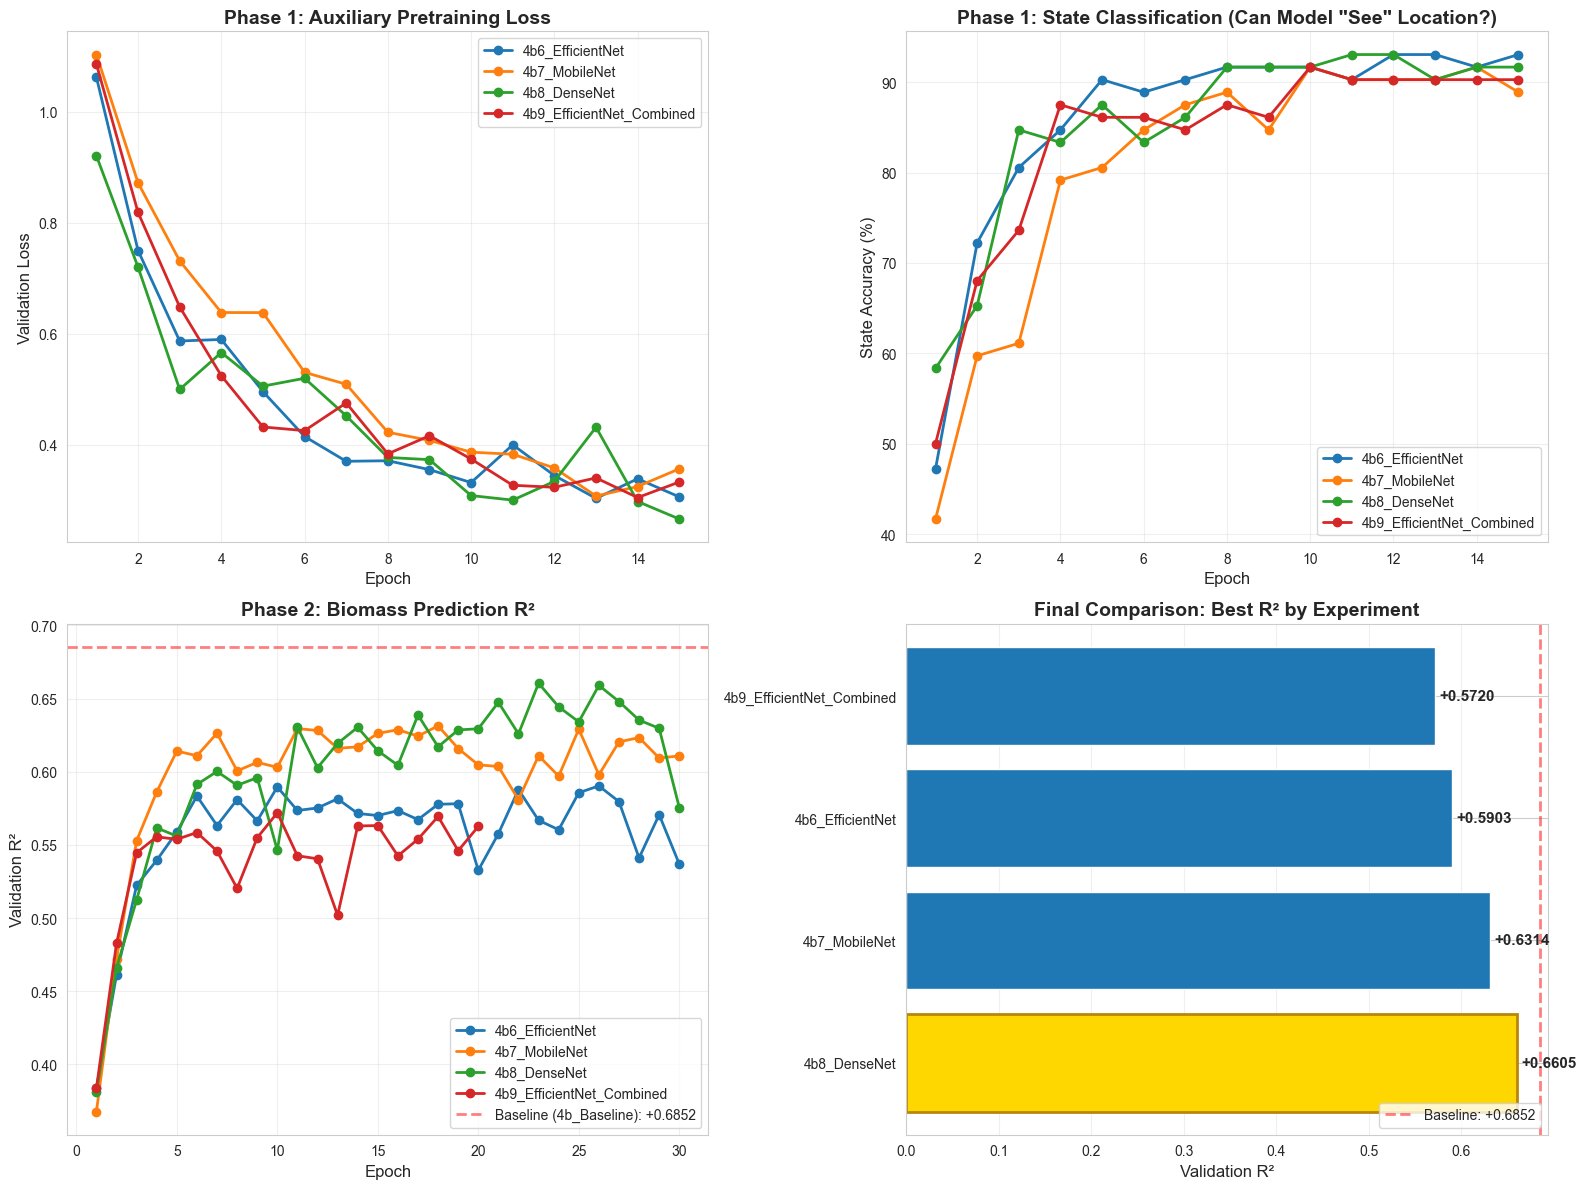


✅ Visualization saved: model4b_remaining_experiments_20251105_182334.png


In [27]:
# Create comprehensive visualization
if len(new_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Phase 1 Validation Loss (Auxiliary Pretraining)
    ax = axes[0, 0]
    for var_name, results in new_results.items():
        history = results['history_phase1']
        epochs = range(1, len(history['val_loss'])+1)
        ax.plot(epochs, history['val_loss'], 'o-', label=var_name, linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Validation Loss', fontsize=12)
    ax.set_title('Phase 1: Auxiliary Pretraining Loss', fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    
    # Plot 2: Phase 1 State Classification Accuracy
    ax = axes[0, 1]
    for var_name, results in new_results.items():
        history = results['history_phase1']
        epochs = range(1, len(history['val_state_acc'])+1)
        state_acc_pct = [acc*100 for acc in history['val_state_acc']]
        ax.plot(epochs, state_acc_pct, 'o-', label=var_name, linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('State Accuracy (%)', fontsize=12)
    ax.set_title('Phase 1: State Classification (Can Model "See" Location?)', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    
    # Plot 3: Phase 2 Validation R² (Biomass Prediction)
    ax = axes[1, 0]
    for var_name, results in new_results.items():
        history = results['history_phase2']
        ax.plot(history['epoch'], history['val_r2'], 'o-', label=var_name, linewidth=2, markersize=6)
    
    # Add baseline reference line
    baseline_r2 = 0.6852
    ax.axhline(y=baseline_r2, color='red', linestyle='--', linewidth=2, alpha=0.5, 
               label=f'Baseline (4b_Baseline): {baseline_r2:+.4f}')
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Validation R²', fontsize=12)
    ax.set_title('Phase 2: Biomass Prediction R²', fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    
    # Plot 4: Final R² Comparison (Bar Chart)
    ax = axes[1, 1]
    
    # Sort by R²
    sorted_results = sorted(new_results.items(), key=lambda x: x[1]['best_r2'], reverse=True)
    exp_names = [name for name, _ in sorted_results]
    r2_values = [res['best_r2'] for _, res in sorted_results]
    
    # Create bars
    bars = ax.barh(exp_names, r2_values)
    
    # Color the best one gold
    bars[0].set_color('gold')
    bars[0].set_edgecolor('darkgoldenrod')
    bars[0].set_linewidth(2)
    
    # Add baseline reference line
    ax.axvline(x=baseline_r2, color='red', linestyle='--', linewidth=2, alpha=0.5,
               label=f'Baseline: {baseline_r2:+.4f}')
    
    # Add value labels
    for i, (name, value) in enumerate(zip(exp_names, r2_values)):
        ax.text(value + 0.005, i, f'{value:+.4f}', 
                va='center', fontsize=11, fontweight='bold')
    
    ax.set_xlabel('Validation R²', fontsize=12)
    ax.set_title('Final Comparison: Best R² by Experiment', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3, axis='x')
    
    plt.tight_layout()
    
    # Save figure
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'model4b_remaining_experiments_{timestamp}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Visualization saved: {filename}")
else:
    print("No results to visualize yet - training may not have completed")

---
## Next Steps

After training completes:

1. **Check results** in `new_results` dictionary
2. **Compare with previous experiments** (4b_Baseline R²=+0.6852)
3. **Run ensemble** if one experiment significantly outperforms others
4. **Create submission** using the best model

### Quick Check
```python
# See all results
for name, res in new_results.items():
    print(f"{name}: R²={res['best_r2']:+.4f}")

# Find best
best = max(new_results.items(), key=lambda x: x[1]['best_r2'])
print(f"\nBest: {best[0]} with R²={best[1]['best_r2']:+.4f}")
```